# City of Melbourne Parking Analysis

In this notebook we analyse real time parking data from the City of Melbourne (CoM). We have set up a process using the prefect library to extract real time parking data in 10 minute intervals.

In [1867]:
import pandas as pd
import numpy as np
import os
import powerlaw
from datetime import timedelta
import re

In [1975]:
# read all files in data folder
df_array = []
file_count = 0

for _file in os.listdir(r'./data_prep/raw_data'):
    if _file != 'raw_data.7z':
        out = pd.read_csv(r'./data_prep/raw_data/' + _file)
        df_array.append(out)
        file_count += 1

df = pd.concat(df_array)
df.datetime = pd.to_datetime(df.datetime)
df.set_index(['datetime','bay_id'], inplace=True)
df

st_marker_id  status
datetime            bay_id                     
2022-01-06 11:20:00 4432          C7704       0
                    5236         11526N       0
                    2655         10159W       1
                    2670         10179W       1
                    1274          4466E       0
...                                 ...     ...
2022-01-13 20:40:00 2643         10117W       0
                    4422          C7684       1
                    4086          C6286       1
                    8335         C7736C       1
                    4069          C6176       0

[954848 rows x 2 columns]

In [1976]:
# parking locations which have data for all counts
obs_counts = df.groupby(level = 'bay_id').count()
obs_counts[(obs_counts.status == file_count)].shape[0]

738

In [1977]:
good_bays = obs_counts[(obs_counts.status == file_count)].index.get_level_values('bay_id').unique()
df = df[df.index.get_level_values('bay_id').isin(good_bays)]
df

st_marker_id  status
datetime            bay_id                     
2022-01-06 11:20:00 4432          C7704       0
                    2655         10159W       1
                    2670         10179W       1
                    4044          C6126       1
                    4257          C6846       0
...                                 ...     ...
2022-01-13 20:40:00 2643         10117W       0
                    4422          C7684       1
                    4086          C6286       1
                    8335         C7736C       1
                    4069          C6176       0

[785970 rows x 2 columns]

In [1978]:
## don't do this here - calculate lag based on prediction gap
# # create dataset
# # variables
# # lagged status
# df.sort_index()
# df['lag1'] = df['status'].groupby(level = 'bay_id').shift(1)
# df['lag2'] = df['status'].groupby(level = 'bay_id').shift(2)
# df['lag3'] = df['status'].groupby(level = 'bay_id').shift(3)
# # neighbouring occupancies (how to find?)
# # restrictions?

# df


We want to build a predictive model of parking in the CoM. We anticipate that we will build this using a classification model, which will classify a parking space as either occupied or not. A likely variable to use in this model will be the lagged values for the parking occupancy (i.e. whether the car space was occupied 10, 20, 30,... minutes ago). We examine various lags below and plot them - looking at the percentage of car spaces that have the same value in different time periods.

We see that as the lag gets larger, the proportion of matching values drops away sharply to flatten out at around 65%. This is interesting given that if the probability of being occupied and unoccupied were equal, we would expect to see this value converge to 50% as the time lag gets larger. As we see it reduce to 65% (approx) it may be that one state is more common than the other.

In [1979]:

out = {'perc':[]}
for i in range(1, 170):
    lagged = df['status'].groupby(level = 'bay_id').shift(i)
    filt = lagged.isna()
    filt_lagged = lagged[~filt]
    filt_curr = df[~filt]
    out['perc'].append(round(100*sum(filt_curr.status == filt_lagged) / filt_curr.shape[0], 1))



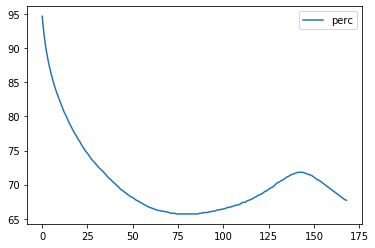

In [1980]:
# seems that closer lags (1 to 5) predict greater than or equal 80% (at this time)
pd.DataFrame(out).plot()

We aggregate all bays across time in df_time and look at the percentage that are occupied. Over time we see that this does not really exceed 45%. It appears that there are generally more unoccupied spots than occupied.
Note that currently this data is extracted for a holiday period during a COVID19 outbreak so this may not reflect normal behaviour - however, it does appear to lend weight to our hypothesis that one parking state is more likely than another. 

To analyse this further we may want to look at whether the occupancy rate varies by location or parking type.

In [1981]:
df_time = df.copy(deep = True)
df_time.reset_index(inplace = True)

dates = pd.DatetimeIndex(df_time.datetime)

df_time = df_time[['bay_id', 'status']].set_index(dates)

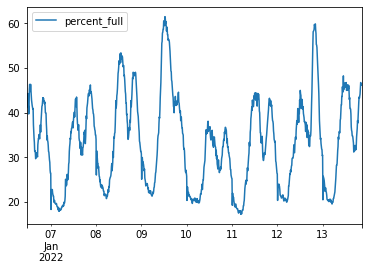

In [1982]:
macro_time_df = pd.DataFrame(index = np.unique(dates))


for date in np.unique(dates):
    macro_time_df.loc[date, 'percent_full'] = 100*df_time.loc[date, 'status'].sum() / df_time.loc[date, 'status'].count()
    #macro_time_df.loc[date, 'lag1_pred'] = 100*df_time.loc[date, 'lag1'].sum() / df_time.loc[date, 'status'].count()

macro_time_df.plot()

# Parking Restrictions
We can use parking restrictions as features in our model. The permitted parking time and time of restrictions are likely to affect parking turnover. Furthermore, we can know these in advance, so they can add some dynamism to our predictions.

Examining parking restriction data below, we see that there are a variety of different restrictions placed on parking spots. These are also not recorded consistently with day names sometimes abbreviated to a single letter or three letter acronym, and times recorded as single numbers or as a full time.

In [1948]:
# parking restrictions data
park_r = pd.read_csv('./data_prep/datasets/parking_bay_restrictions.csv')
park_r.rename(columns = {'BayID': 'bay_id'}, inplace = True) # for consistency with other datasets
park_r.set_index('bay_id', inplace = True) 

# get all parking bays in real time data
bay_ids = np.unique(df.index.get_level_values(1))
park_r = park_r.iloc[np.where([i for i in park_r.index if i in bay_ids])[0]]


In [1949]:
from datetime import datetime

def extract_hrs(string):
    pattern = r'\dP'
    res = re.match(pattern, string)
    if res:
        return res.group()
    else:
        return '0'
        
def str_24convert(string_time):
    if 'p' in string_time.lower():
        ints = re.split(r'(:|\.|[AaPpMm])', string_time, maxsplit=1)
        ints[0] = str(12 + int(ints[0]))

        return ''.join(ints).strip().strip(r'[AaPpMm]').replace('.',':')
        
    else:
        ints = re.split(r'(:|\.|[AaPpMm])', string_time, maxsplit=1)
        return string_time.strip().strip(r'[AaPpMm]').replace('.',':')

def get_time_bracket(string_time):
    pattern = r'\d+(:|.)\d+(AM|am|PM|pm)?(\s?-\s?|\s?TO\s?)\d+(:|.)\d+(AM|am|PM|pm)?'
    res = re.search(pattern, text)
    if res:
        return list(str_24convert(t) for t in re.split(r'-|TO', res.group()))
    else:
        return ['00:00', '23:59']


In [1950]:
all_park_df = df.join(park_r, how = 'inner')
all_park_df['restrictions'] = 0

for park in park_r.index.values:

    times = get_time_bracket(park_r.loc[park, 'Description1'])

    mask = (all_park_df.index.get_level_values(0).time >= datetime.time(datetime.strptime(times[0], '%H:%M'))) & \
        (all_park_df.index.get_level_values(0).time <= datetime.time(datetime.strptime(times[1], '%H:%M'))) & \
            (all_park_df.index.get_level_values(1) == park)

    all_park_df.loc[mask, 'restrictions'] = all_park_df.loc[mask, 'TypeDesc1'].apply(lambda x: extract_hrs(x)).to_numpy()

    

In [1951]:
all_park_df.restrictions.unique()

array(['2P', '1P', '4P', '3P', '0', 0], dtype=object)

In [1967]:
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder()
# set up modelling data
estimation_data = all_park_df[['status', 'restrictions']].copy(deep = True)
dummies = pd.get_dummies(estimation_data.restrictions, drop_first = True)
estimation_data = estimation_data[['status']].astype(int)
estimation_data = pd.merge(estimation_data, dummies, left_index = True, right_index = True)
estimation_data.sort_index(inplace = True)

# include hour variable
estimation_data['time_hour'] = estimation_data.index.get_level_values(0).hour
time_dummies = pd.get_dummies(estimation_data.time_hour, drop_first = True)
estimation_data = pd.merge(estimation_data, time_dummies, left_index = True, right_index = True)
estimation_data.sort_index(inplace = True)

# include day variable
estimation_data['time_day'] = estimation_data.index.get_level_values(0).day_name() 
day_dummies = pd.get_dummies(estimation_data.time_day, drop_first = True)
estimation_data = pd.merge(estimation_data, day_dummies, left_index = True, right_index = True)
estimation_data.sort_index(inplace = True)

# extract test and train data
most_recent = np.max(estimation_data.index.get_level_values(0))
# how far ahead to predict in minutes
interval = 30
split = most_recent - timedelta(minutes = interval)

# calc appropriate lag
estimation_data['lag1'] = estimation_data['status'].groupby(level = 'bay_id').shift(interval / 10)
estimation_data['lag2'] = estimation_data['status'].groupby(level = 'bay_id').shift(interval / 10 + 1)
estimation_data['lag3'] = estimation_data['status'].groupby(level = 'bay_id').shift(interval / 10 + 2)

# 24 hr lag
estimation_data['lag24'] = estimation_data['status'].groupby(level = 'bay_id').shift(144)

# get single period lag for change calc
estimation_data['changes'] = estimation_data.lag1 != estimation_data.lag2
estimation_data['changes'] = estimation_data.changes.rolling(window = 6).mean()

estimation_data = estimation_data[~(estimation_data.lag1.isna()|estimation_data.lag24.isna()|estimation_data.lag2.isna()|estimation_data.lag3.isna())]

test = estimation_data.loc[(split + timedelta(minutes = 10)):] # retain datetime index
train = estimation_data.loc[:split]

# 'lag1','lag2', 'lag3',
features = ['lag24','lag1','lag2', 'lag3']#, 'Monday', 'Tuesday', 'Wednesday','Saturday', 'Sunday', '1P', '2P', '4P'] + [i for i in range(1, 24)]

X_test = test[features]
Y_test = test['status']
X_train = train[features]
Y_train = train['status']

In [1953]:
estimation_data

status  0  1P  2P  3P  4P  time_hour  1  2  3  \
datetime            bay_id                                                  
2022-01-07 11:20:00 863          0  0   1   0   0   0         11  0  0  0   
                    1528         1  0   1   0   0   0         11  0  0  0   
                    1837         0  1   0   0   0   0         11  0  0  0   
                    1838         1  1   0   0   0   0         11  0  0  0   
                    1839         0  1   0   0   0   0         11  0  0  0   
...                            ... ..  ..  ..  ..  ..        ... .. .. ..   
2022-01-12 19:30:00 5862         1  0   0   0   0   0         19  0  0  0   
                    5882         1  0   0   0   0   0         19  0  0  0   
                    5886         1  0   0   0   0   0         19  0  0  0   
                    6695         1  0   0   0   0   0         19  0  0  0   
                    7057         1  0   0   0   0   0         19  0  0  0   

                            ...  Saturday  Sunday  Thursday  Tuesday  \
datetime            bay_id  ...                                        
2022-01-07 11:20:00 863     ...         0       0         0        0   
                    1528    ...         0       0         0        0   
                    1837    ...         0       0         0        0   
                    1838    ...         0       0         0        0   
                    1839    ...         0       0         0        0   
...                         ...       ...     ...       ...      ...   
2022-01-12 19:30:00 5862    ...         0       0         0        0   
                    5882    ...         0       0         0        0   
                    5886    ...         0       0         0        0   
                    6695    ...         0       0         0        0   
                    7057    ...         0       0         0        0   

                            Wednesday  lag1  lag2  lag3  lag24   changes  
datetime            bay_id                                                
2022-01-07 11:20:00 863             0   0.0   0.0   0.0    0.0  0.333333  
                    1528            0   1.0   1.0   1.0    1.0  0.166667  
                    1837            0   0.0   0.0   1.0    0.0  0.166667  
                    1838            0   1.0   0.0   0.0    0.0  0.166667  
                    1839            0   0.0   1.0   0.0    1.0  0.333333  
...                               ...   ...   ...   ...    ...       ...  
2022-01-12 19:30:00 5862            1   1.0   1.0   0.0    1.0  0.166667  
                    5882            1   1.0   1.0   1.0    0.0  0.166667  
                    5886            1   1.0   1.0   0.0    0.0  0.166667  
                    6695            1   1.0   1.0   1.0    1.0  0.000000  
                    7057            1   1.0   1.0   1.0    0.0  0.000000  

[76230 rows x 42 columns]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  


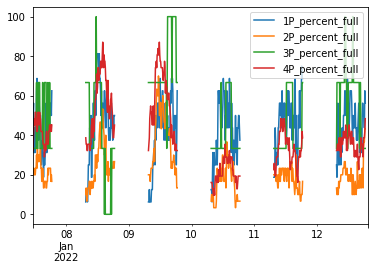

In [1954]:
dates = estimation_data.index.get_level_values(0)
macro_time_df_all = pd.DataFrame(index = np.unique(dates))


for date in np.unique(dates):
    for _type in ['1P', '2P', '3P', '4P']:
        date_df = estimation_data.loc[date]
        macro_time_df_all.loc[date, f'{_type}_percent_full'] = 100*date_df.loc[date_df[_type] == 1, 'status'].sum() / date_df.loc[date_df[_type] == 1, 'status'].count()


macro_time_df_all.plot()

In [1955]:
estimation_data.loc['2022-Jan-7 16:30', ['1P', '2P', '4P']].sum()

1P    16
2P    30
4P    31
dtype: int64

In [1960]:
X_train.loc['2022-Jan-8 10:00']

lag24  lag1  lag2  lag3  Monday  Tuesday  \
datetime            bay_id                                             
2022-01-08 10:00:00 863       0.0   0.0   0.0   0.0       0        0   
                    1528      1.0   1.0   1.0   1.0       0        0   
                    1837      1.0   0.0   0.0   0.0       0        0   
                    1838      0.0   0.0   0.0   0.0       0        0   
                    1839      0.0   0.0   0.0   0.0       0        0   
...                           ...   ...   ...   ...     ...      ...   
                    5862      0.0   0.0   0.0   0.0       0        0   
                    5882      1.0   0.0   0.0   0.0       0        0   
                    5886      1.0   0.0   0.0   0.0       0        0   
                    6695      1.0   1.0   1.0   1.0       0        0   
                    7057      0.0   0.0   0.0   0.0       0        0   

                            Wednesday  Saturday  Sunday  1P  ...  14  15  16  \
datetime            bay_id                                   ...               
2022-01-08 10:00:00 863             0         1       0   1  ...   0   0   0   
                    1528            0         1       0   1  ...   0   0   0   
                    1837            0         1       0   0  ...   0   0   0   
                    1838            0         1       0   0  ...   0   0   0   
                    1839            0         1       0   0  ...   0   0   0   
...                               ...       ...     ...  ..  ...  ..  ..  ..   
                    5862            0         1       0   0  ...   0   0   0   
                    5882            0         1       0   0  ...   0   0   0   
                    5886            0         1       0   0  ...   0   0   0   
                    6695            0         1       0   0  ...   0   0   0   
                    7057            0         1       0   1  ...   0   0   0   

                            17  18  19  20  21  22  23  
datetime            bay_id                              
2022-01-08 10:00:00 863      0   0   0   0   0   0   0  
                    1528     0   0   0   0   0   0   0  
                    1837     0   0   0   0   0   0   0  
                    1838     0   0   0   0   0   0   0  
                    1839     0   0   0   0   0   0   0  
...                         ..  ..  ..  ..  ..  ..  ..  
                    5862     0   0   0   0   0   0   0  
                    5882     0   0   0   0   0   0   0  
                    5886     0   0   0   0   0   0   0  
                    6695     0   0   0   0   0   0   0  
                    7057     0   0   0   0   0   0   0  

[99 rows x 35 columns]

# Modelling

Using the features we have extracted, we now estimate a model which classifies a parking space as occupied or empty.


In [1957]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


[[0.68286464 2.5720601  0.93876866 1.14157212]]


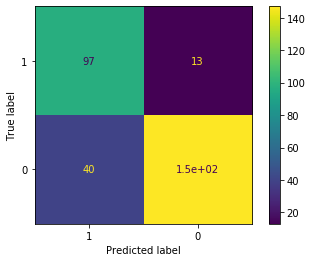

In [1968]:
LR = LogisticRegression(random_state=1)
LR.fit(X_train, Y_train)

pred = LR.predict(X_test)
cm = confusion_matrix(Y_test, pred)
ConfusionMatrixDisplay(cm, display_labels = [1,0]).plot()
print(LR.coef_)

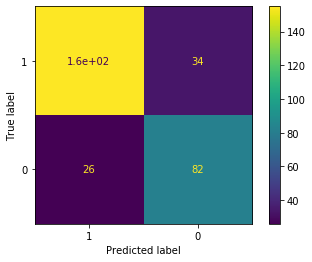

In [1933]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, Y_train)

pred = rf.predict(X_test)
cm = confusion_matrix(Y_test, pred)
ConfusionMatrixDisplay(cm, display_labels = [1,0]).plot()

In [1771]:
# running cross validation across all obs
acc = {'acc': [], 'occ': []}

for date in np.unique(estimation_data.index.get_level_values(0)):

    rf.fit(estimation_data.loc[date - np.timedelta64(10, 'm'):, features], estimation_data.loc[date - np.timedelta64(10, 'm'):, 'status'])
    pred = rf.predict(estimation_data.loc[date, features])
    cm = confusion_matrix(estimation_data.loc[date,'status'], pred)
    accuracy = (cm[0][0] + cm[1][1]) / np.sum(cm)
    occupancy = 100* pred.sum() / len(pred)
    acc['acc'].append(accuracy)
    acc['occ'].append(occupancy)
    #ConfusionMatrixDisplay(cm, display_labels = [1,0]).plot()

In [1969]:
# running cross validation across all obs
acc = {'acc': [], 'occ': []}

for date in np.unique(estimation_data.index.get_level_values(0)):

    LR.fit(estimation_data.loc[date - np.timedelta64(10, 'm'):, features], estimation_data.loc[date - np.timedelta64(10, 'm'):, 'status'])
    pred = LR.predict(estimation_data.loc[date, features])
    cm = confusion_matrix(estimation_data.loc[date,'status'], pred)
    accuracy = (cm[0][0] + cm[1][1]) / np.sum(cm)
    occupancy = 100* pred.sum() / len(pred)
    acc['acc'].append(accuracy)
    acc['occ'].append(occupancy)
    #ConfusionMatrixDisplay(cm, display_labels = [1,0]).plot()

In [946]:
def combine_preds(X, Y, pred):
    
    curr_date = np.max(X.index.get_level_values(0))
    # get next interval
    next_date = curr_date + timedelta(minutes = 10)

    # update indicies and get new df
    new_date_index = np.tile(next_date, len(pred))
    new_park_index = X.index.get_level_values(1).unique()
    new_multi_index = pd.MultiIndex.from_tuples(list(zip(new_date_index, new_park_index)))

    new_data = pd.DataFrame({'status' : pred}, index = new_multi_index)

    # merge and create combined df
    temp_train = pd.merge(X, Y, left_index = True, right_index = True)
    combined = pd.concat([new_data, temp_train])
    combined.sort_index(inplace = True)

    # update lagged values
    for i in [1,2,3]:

        s = next_date - timedelta(minutes = i*10)
        lag_vals = Y.loc[s, ].to_numpy()
        #print(lag_vals.shape, combined.loc[next_data].shape)
        combined.loc[next_date, f'lag{i}'] = lag_vals
    
    

    return combined

def iterative_forecast(model, X_train, Y_train, X_test, n_ahead):
    train_vars = X_train
    train_target = Y_train
    
    last_date = np.max(X_train.index.get_level_values(0)) 

    test_vars = X_test.loc[last_date + timedelta(minutes = 10),]


    # iterate through dates
    for i in range(1, n_ahead + 1):
        pred = model.predict(test_vars) # already fitted model

        new_data = combine_preds(train_vars, train_target, pred)

        train_target = new_data['status']
        train_vars = new_data[['lag1', 'lag2', 'lag3', '1P', '2P', '3P', '4P']]
        test_vars = new_data.loc[last_date + timedelta(minutes = 10 * i),['lag1', 'lag2', 'lag3', '1P', '2P', '3P', '4P']]

    return new_data.loc[last_date + timedelta(minutes = 10):,]


#LR.predict(X_test)
#k = combine_preds(X_train, Y_train, LR.predict(X_test))
fcast = iterative_forecast(LR, X_train, Y_train, X_test, 10)



ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

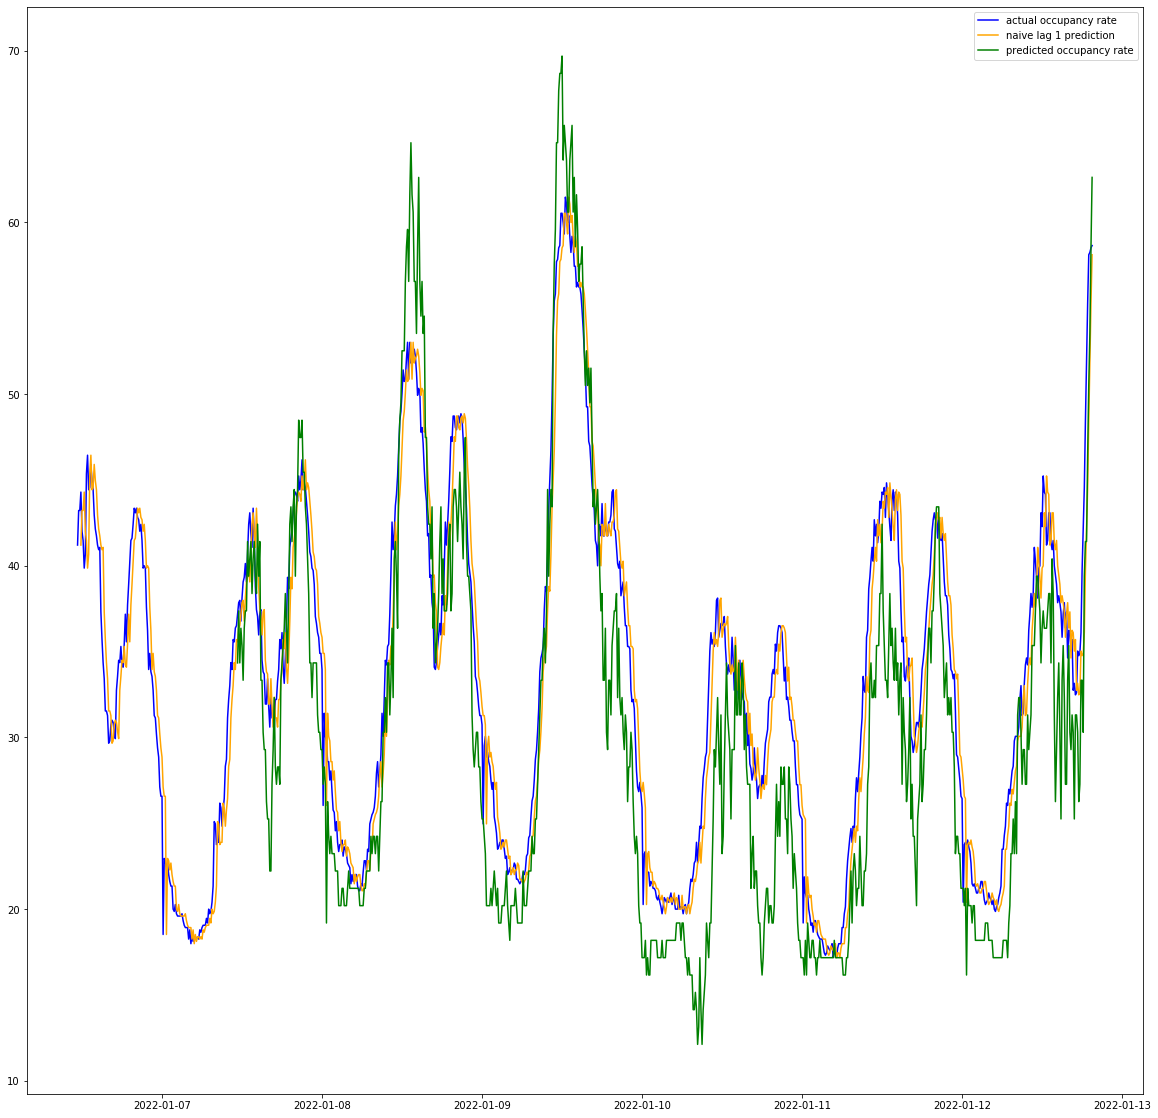

In [1970]:
acc_df = pd.DataFrame(acc, index = np.unique(estimation_data.index.get_level_values(0)))
## analyse the implied occupancy rate
plt.figure(figsize = (20,20))
# does not really provide an advantage over a naive lagged 1 prediction
plt.plot(macro_time_df.loc[:, 'percent_full'], c = 'blue', label = 'actual occupancy rate')
plt.plot(macro_time_df.loc[:, 'percent_full'].shift(3), c = 'orange', label = 'naive lag 1 prediction')
#plt.plot(macro_time_df.loc[:, 'percent_full'].shift(6), c = 'red', label = 'naive lag 6 prediction')
#plt.plot(fcast_occ.index, fcast_occ['percent_full'], 'or', label = 'predicted')
plt.plot(acc_df['occ'].index, acc_df['occ'],'g', label = 'predicted occupancy rate')

plt.legend()
plt.show()


['lag24', 'lag1', 'lag2', 'lag3'] 
 [[0.64485251 2.14513108 0.82582025 0.31679969]]


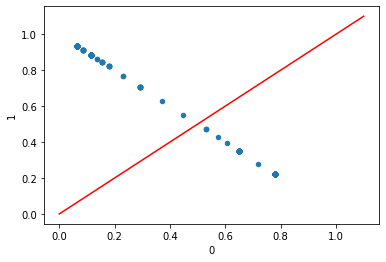

In [1971]:
pd.DataFrame(LR.predict_proba(X_test)).plot(x = 0, y = 1,kind = 'scatter')
plt.plot(np.linspace(0,1.1), np.linspace(0,1.1), c = 'red')
print(features,
'\n',


LR.coef_)

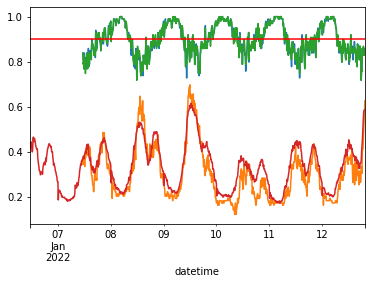

In [1973]:
new = estimation_data.lag1 == estimation_data.status
lag_acc = new.groupby(level = 'datetime').sum() / new.groupby(level = 'datetime').count()
acc_df['acc'].plot()
(acc_df['occ']/100).plot()
lag_acc.plot()
(macro_time_df.loc[:, 'percent_full']/100).plot()
plt.axhline(acc_df['acc'].mean(), c = 'r')
#plt.axhline(lag_acc.mean(), c = 'g')

In [1974]:
print(lag_acc.mean(), acc_df.acc.mean())

0.9010232192050445 0.8997507542962142


0.9018273920415297


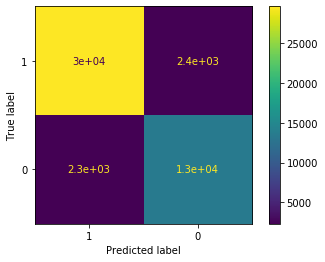

In [1866]:
cm = confusion_matrix(estimation_data.status, estimation_data.lag1)
accuracy = (cm[0][0] + cm[1][1]) / np.sum(cm)
ConfusionMatrixDisplay(cm, display_labels = [1,0]).plot()
print(accuracy)

In [1863]:
print(features,
'\n',
LR.coef_)

['lag24', 'lag1', 'lag2', 'lag3', 'Monday', 'Saturday', 'Sunday', 'Thursday', '1P', '2P', '4P', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] 
 [[ 1.01202481e+00  1.40285707e+00  1.64748094e+00  1.59463891e+00
  -2.53362796e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.05137430e+00 -1.95027562e-01  5.86337399e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.77626685e-02
   2.77373323e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


unique_parks

In [1159]:
# count the number of status changes
df['change'] = df.status != df.lag1
changes = df.loc[~df.change.isna(),'change'].groupby(level = 'bay_id').sum()

# can look at changes per hour? changes by area? plot this as a graph?
plt.hist(changes - 1, density = True)

AttributeError: 'DataFrame' object has no attribute 'lag1'

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
C:\ProgramData\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
C:\ProgramData\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
C:\ProgramData\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
C:\ProgramData\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


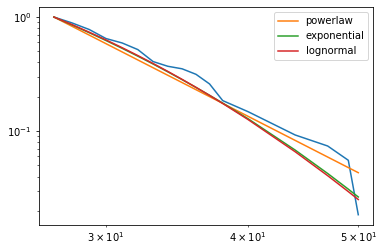

In [338]:

res = powerlaw.Fit(changes - 1)
fig = res.plot_ccdf()
res.power_law.plot_ccdf(ax = fig, label = 'powerlaw')
res.exponential.plot_ccdf(ax = fig, label = 'exponential')
res.lognormal.plot_ccdf(ax = fig, label = 'lognormal')
fig.legend()

In [233]:
# think about:
# what variables do you want for predictions? e.g. lags, neighbouring occupancy, parking restrictions
# what are some overall statistics? e.g. changes per hour, % occupied,% unoccupied (at a time, or in an area or both)
# what sort of model? - thinking classification model, using lags and other variables. start with logisitic regression?


,bay_id,datetime,st_marker_id,status,lag1,lag2,lag3,change
0,4432,2022-01-06 11:20:00,C7704,0,NaN,NaN,NaN,True
1,5236,2022-01-06 11:20:00,11526N,0,NaN,NaN,NaN,True
2,2655,2022-01-06 11:20:00,10159W,1,NaN,NaN,NaN,True
3,2670,2022-01-06 11:20:00,10179W,1,NaN,NaN,NaN,True
4,1274,2022-01-06 11:20:00,4466E,0,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...
119938,2643,2022-01-07 10:30:00,10117W,0,1.0,0.0,0.0,True
119939,4422,2022-01-07 10:30:00,C7684,1,1.0,1.0,1.0,False
119940,4086,2022-01-07 10:30:00,C6286,1,1.0,1.0,1.0,False
119941,8335,2022-01-07 10:30:00,C7736C,0,0.0,0.0,0.0,False


Below we look at the % occupancy of parking spots across the City of Melbourne by time.

In [277]:
df_time = df.copy(deep = True)
df_time.reset_index(inplace = True)

dates = pd.DatetimeIndex(df_time.datetime)

df_time = df_time[['bay_id', 'status', 'lag1', 'lag2', 'lag3']].set_index(dates)

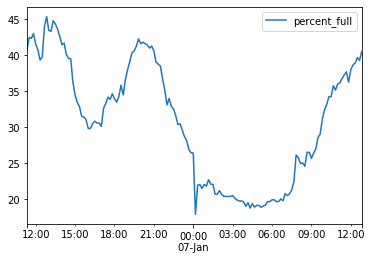

In [278]:
macro_time_df = pd.DataFrame(index = np.unique(dates))


for date in np.unique(dates):
    macro_time_df.loc[date, 'percent_full'] = 100*df_time.loc[date, 'status'].sum() / df_time.loc[date, 'status'].count()

macro_time_df.plot()

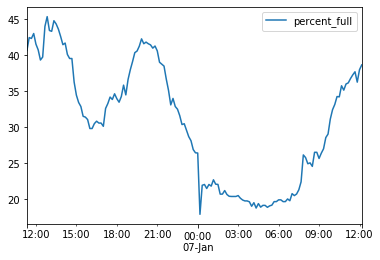